In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


ImportError: Module use of python310.dll conflicts with this version of Python.

In [3]:
# Load the datasets
player_positions = pd.read_csv('data/train_locs.csv')
game_outcomes = pd.read_csv('data/train_pbp.csv')

player_positions = player_positions.to_numpy()

In [4]:

# Parameters
court_length, court_width = 47, 50
grid_size = 1  # 1 foot grid size
n_classes = 2  # Offensive rebound or not

# Convert court dimensions to a grid
n_rows, n_cols = int(court_length / grid_size), int(court_width / grid_size)

def positions_to_grid(players):
    # Initialize an empty grid
    grid = np.zeros((court_length, court_width, 1))  # Single channel for player positions
    
    # if shooter is on the right side of the court, flip the coordinates
    if players[5, 1] > 47:
        for i in range(10):
            players[i, 1] = 94 - players[i, 1]
            players[i, 2] = 50 - players[i, 2]

    # Map player positions to grid
    for row in players:
        x, y, code = min(int(row[1] // grid_size),  - 1), min(int(row[2] // grid_size), n_cols - 1), row[3]
        if 'd' in code:  # Defense
            grid[x, y, 0] = 1
        elif 't' in code:  # Offense excluding shooter
            grid[x, y, 0] = 2
        elif 's' in code:  # Shooter
            grid[x, y, 0] = 3
    
    return grid

X = np.array([positions_to_grid(player_positions[i*10:(i+1)*10, :]) for i in range(int(player_positions.shape[0]/10))])

y = game_outcomes["is_oreb"].to_numpy()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24644, 47, 50, 1), (6161, 47, 50, 1), (24644,), (6161,))

In [6]:

# Separate the dataset into offensive and defensive rebounds
offensive_indices = np.where(y_train == 1)[0]
defensive_indices = np.where(y_train == 0)[0]


# Now, let's make sure we sample an equal number of examples for both classes
# Determine the size of the smaller class to balance the dataset
min_size = min(len(offensive_indices), len(defensive_indices))

# Randomly sample from the larger class to match the size of the smaller class
offensive_indices_balanced = np.random.choice(offensive_indices, min_size, replace=False)
defensive_indices_balanced = np.random.choice(defensive_indices, min_size, replace=False)

# Combine the indices and then split
balanced_indices = np.concatenate([offensive_indices_balanced, defensive_indices_balanced])

# Extract the balanced dataset
X_balanced = X_train[balanced_indices]
y_balanced = y_train[balanced_indices]

# Now X_train, X_test have a 50/50 split of offensive and defensive rebounds

In [7]:
X_balanced.shape, y_balanced.shape

((13888, 47, 50, 1), (13888,))

In [ ]:
from tensorflow.keras.layers import Masking, Input, Conv2D, MaxPooling2D, Flatten, Dense, Multiply, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Define the model
model = Sequential()
model.add(Masking(mask_value=0, input_shape=(court_length, court_width, 1)))
model.add(Conv2D(32, (10, 10), activation='relu'))
# add another convolution layer
model.add(Conv2D(32, (3, 3), activation='relu'))
# add final layers
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 47, 50, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 41, 32)        3232      
                                                                 
 conv2d_4 (Conv2D)           (None, 36, 39, 32)        9248      
                                                                 
 flatten_2 (Flatten)         (None, 44928)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                1437728   
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

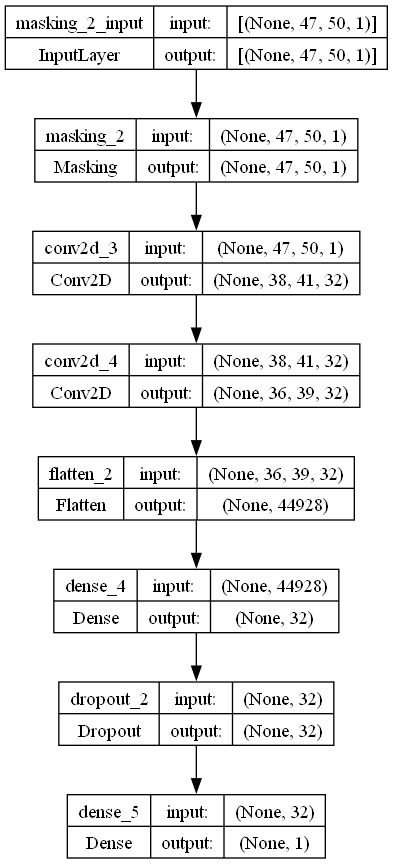

In [16]:
from keras.utils import plot_model

# Assuming `model` is your Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
history = model.fit(X_balanced, y_balanced,
                    batch_size=32,
                    epochs=10,  # Adjust based on convergence and computational resources
                    validation_data=(X_test, y_test))

Epoch 1/10
434/434 [==============================] - 10s 23ms/step - loss: 0.6794 - accuracy: 0.5658 - val_loss: 0.6898 - val_accuracy: 0.5554
Epoch 2/10
434/434 [==============================] - 10s 23ms/step - loss: 0.6790 - accuracy: 0.5680 - val_loss: 0.6966 - val_accuracy: 0.5449
Epoch 3/10
434/434 [==============================] - 10s 22ms/step - loss: 0.6760 - accuracy: 0.5750 - val_loss: 0.7041 - val_accuracy: 0.5251
Epoch 4/10
434/434 [==============================] - 10s 23ms/step - loss: 0.6745 - accuracy: 0.5824 - val_loss: 0.7031 - val_accuracy: 0.5426
Epoch 5/10
434/434 [==============================] - 10s 22ms/step - loss: 0.6710 - accuracy: 0.5832 - val_loss: 0.6864 - val_accuracy: 0.5752
Epoch 6/10
434/434 [==============================] - 10s 23ms/step - loss: 0.6677 - accuracy: 0.5904 - val_loss: 0.6919 - val_accuracy: 0.5590
Epoch 7/10
434/434 [==============================] - 11s 24ms/step - loss: 0.6620 - accuracy: 0.5945 - val_loss: 0.6989 - val_accuracy:

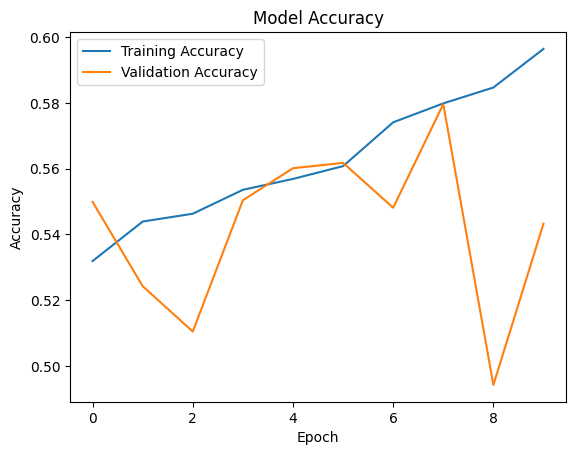

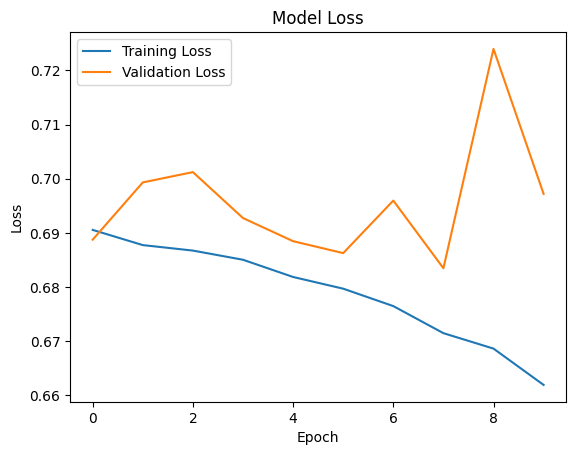

In [11]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()